In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
import scipy.integrate
import scipy.optimize

In [2]:
T = 473.        # K. remember decimal points on non-integers!
R = 8.314      # J/mol/K
Ca0 = 100.     # mole/m3
v0 = 120.      # m3/hr
Fa0 = Ca0 * v0

Price_a = 200.  # $/kmol
Price_b = 300.  # $/kmol
Price_r = 1000. # $/kmol
Cost_SQ = 5.    # $/mol

def k1(T):
    A = 0.05  # m3/mol/s
    Ea = 6000. # J
    return A*np.exp(-1*Ea / R / T)

def k2(T):
    A = 1.0    # m3/mol/s
    Ea = 12500. # J
    return A*np.exp(-1*Ea / R / T)

def k3(T):
    A = 0.08  # m3/mol/s
    Ea = 7000. # J
    return A*np.exp(-1*Ea / R / T)

def k4(T):
    A = 0.06  # m3/mol/s
    Ea = 9000. # J
    return A*np.exp(-1*Ea / R / T)

In [3]:
def dFsoldV(Fsol,V):
    Fa, Fb, Fr, Fs, Fq = Fsol # unpack values from Fsol vector into 
                              # five variables

    # Total molar flowrate:
    Ft = Fa + Fb + Fr + Fs + Fq
    # Total concentration, from ideal gas law:
    Ct = 100. #mol/m3
    # Concentrations:
    Ca = Ct * (Fa / Ft)
    Cb = Ct * (Fb / Ft)
    Cr = Ct * (Fr / Ft)
    Cs = Ct * (Fs / Ft)
    Cq = Ct * (Fq / Ft)
    # rates of progress of reactions
    r1 = k1(T) * Ca
    r2 = k2(T) * Cb**2
    r3 = k3(T) * Cb
    r4 = k4(T) * Cb
    # rates of generation of species
    ra = -r1
    rb = r1 - (r2 + r3 + r4)
    rr = r2
    rs = r3
    rq = r4
    # Differential equations
    dFadV = ra
    dFbdV = rb
    dFrdV = rr
    dFsdV = rs
    dFqdV = rq
    return[dFadV,dFbdV,dFrdV,dFsdV,dFqdV]


In [4]:
V_output = np.linspace(0,100000.,num=10000)

In [5]:
Fsol0 = [Fa0,0,0,0,0]

In [6]:
Y_result = scipy.integrate.odeint(dFsoldV, Fsol0, V_output)
Fa, Fb, Fr, Fs, Fq = Y_result.T

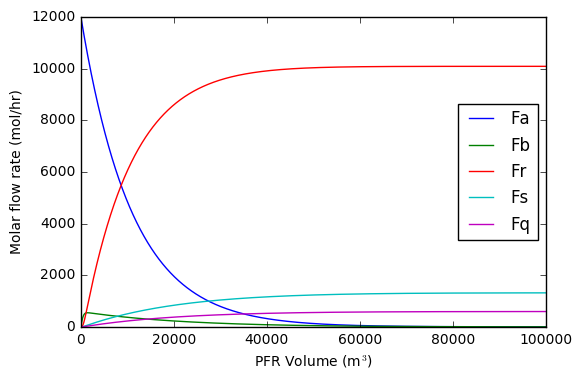

In [7]:
plt.plot(V_output, Fa, label='Fa')
plt.plot(V_output, Fb, label='Fb')
plt.plot(V_output, Fr, label='Fr')
plt.plot(V_output, Fs, label='Fs')
plt.plot(V_output, Fq, label='Fq')
plt.legend(loc="best")
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Molar flow rate (mol/hr)')
plt.show()

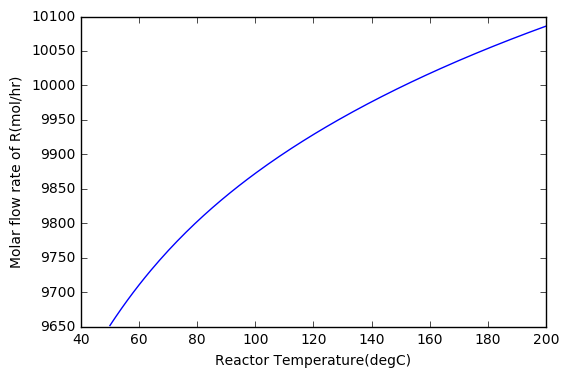

In [29]:
final_r=[]
Trange = np.linspace(323,473,150)
for i in Trange:
    T = i
    solution=scipy.integrate.odeint(dFsoldV,Fsol0,V_output)
    Fa, Fb, Fr, Fs, Fq = solution.T
    final_r.append(Fr[-1])

plt.plot(Trange-273,final_r)
plt.xlabel('Reactor Temperature(degC)')
plt.ylabel('Molar flow rate of R(mol/hr)')
plt.show()

In [8]:
P_a = Price_a * Fa0/1000.
P_b = Price_b * Fb/1000.
P_r = Price_r * Fr/1000.
P_s = Cost_SQ * Fs
P_q = Cost_SQ * Fq
P_tot = P_r - P_a - P_s - P_q

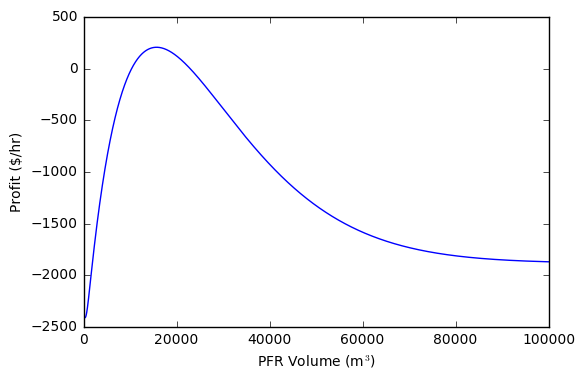

In [9]:
plt.plot(V_output, P_tot)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Profit ($/hr)')
plt.show()

In [32]:
max_y = np.max(P_tot)
max_x = V_output[np.argmax(P_tot)]

print("The max profit is ${:5.2f}/hour.".format(max_y))
print("This occurs at reactor volume %.2f m3." %max_x)

The max profit is $206.08/hour.
This occurs at reactor volume 15691.57 m3.


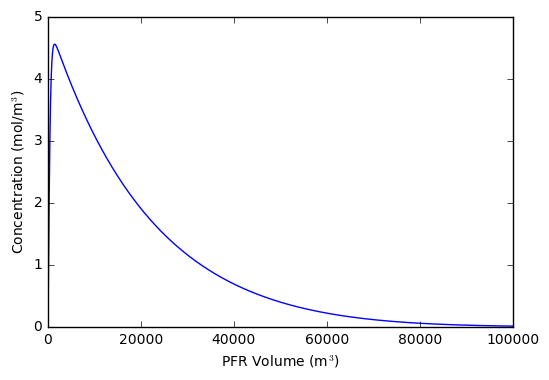

In [11]:
Cb = Fb/v0 #Ft
plt.plot(V_output, Cb)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Concentration (mol/m$^3$)')
plt.show()

In [12]:
max_Cb = np.max(Cb)
max_Vselect = V_output[np.argmax(Cb)]
#print(max_Vselect, max_Cb)
print("The maximum concentration of B under these conditions is %.2f mol/m3." %max_Cb)

The maximum concentration of B under these conditions is 4.56 mol/m3.


In [13]:
selectivity = k2(473.)/(k3(473.) + k4(473.))*max_Cb
print("The maximum selectivity of the desired to the undesired is %.2f." %selectivity)
print("This occurs at a reactor volume of %.2f m3." %max_Vselect)

The maximum selectivity of the desired to the undesired is 9.70.
This occurs at a reactor volume of 1430.14 m3.


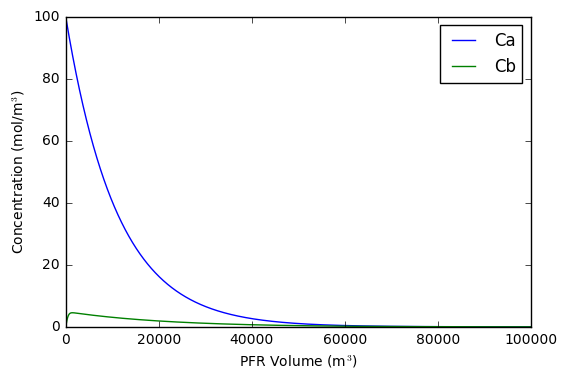

In [14]:
Ca = Fa/v0
Cb = Fb/v0 #Ft
plt.plot(V_output, Ca, label='Ca')
plt.plot(V_output, Cb, label='Cb')
plt.legend(loc="best")
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Concentration (mol/m$^3$)')
plt.show()

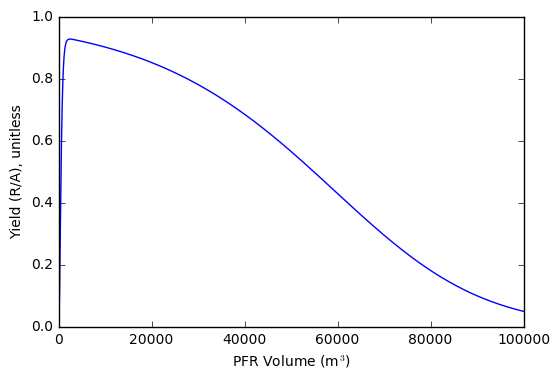

In [15]:
yield_tot = k2(473.)/k1(473.) * (Cb**2/Ca)
plt.plot(V_output, yield_tot)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Yield (R/A), unitless')
plt.show()

In [17]:
max_yield = np.max(yield_tot)
max_Vyield = V_output[np.argmax(yield_tot)]
print("The maximum yield is {:05.3f}, which occurs at a reactor volume of {:07.2f} m3.".format(max_yield,max_Vyield))

The maximum yield is 0.928, which occurs at a reactor volume of 2450.25 m3.
